In [1]:
'''
setting up slabspec code for running on angela and generating first guesses for a given disk

This currently has CO hard-coded!! H2O and 13CO are also otions. 
**make seperate scripts for H2O and 13CO guesses. will be easiest to run those in parallel instead of all at once

**have a (new) default config file. name it something generic

'''

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.constants import c
from astropy import units as un
from astropy.table import Table, vstack
import pickle as pickle
import os as os
import pandas as pd
import math
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from scipy.stats import chisquare

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape, helpers

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

# !! import this to angela
from LineFluxCalcandFit_Functions import *

# Load data, define variables  - - - - - - - - - - - - - - - - - - - -
#Read in FITS data containing spectrum.

datafile = '/Users/emmadahl/Desktop/Slabs/Data/FZTau_fullstack.csv'
distance = 129 # !! need to add this variable to code

wl, flux, flux_error, wl_min, wl_max, w_min_inter, w_max_inter = readin(datafile)

cont_jy = 1.05 # define continuum value, if any

# add query for plotting here, and then include that keyword in LineFluxCalcandFit_Functions
# distance needs to be here as well, used later for things as au

# Load hitran data  - - - - - - - - - - - - - - - - - - - -

# if want to look at low- and high-J terms seperately:
hitran_data = extract_hitran_data('CO', 4.63, 5.17, vup=1)
#hitran_CO_2 = extract_hitran_data('CO', 4.63, 5.17, vup=2) 
#hitran_CO = extract_hitran_data('CO', 4.63, 5.17)
#hitran_13CO = extract_hitran_data('CO', 4.63, 5.17, isotopologue_number=2)
#hitran_H2O = extract_hitran_data('H2O', 4.63, 5.17)


'''df = pd.read_csv(datafile, na_values=["nan"]) 
# get rid of any negative fluxes
wl = df.drop(np.where(flux < 0)[0])['wave']
flux_error = df.drop(np.where(flux < 0)[0])['uflux']
flux = df.drop(np.where(flux < 0)[0])['flux']
wl_min = np.min(wl); wl_max = np.max(wl)'''


/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/utils/utils.py:775: SyntaxWarning: invalid escape sequence '\m'
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/utils/utils.py:775: SyntaxWarning: invalid escape sequence '\m'
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/slab_fitter/output.py:134: SyntaxWarning: invalid escape sequence '\l'
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/slab_fitter/output.py:154: SyntaxWarning: invalid escape sequence '\l'
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/slab_fitter/output.py:189: SyntaxWarning: invalid escape sequence '\m'
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/slab_fitter/output.py:134: SyntaxWarning: invalid escape sequence '\l'
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3

'df = pd.read_csv(datafile, na_values=["nan"]) \n\n\n# get rid of any negative fluxes\nwl = df.drop(np.where(flux < 0)[0])[\'wave\']\nflux_error = df.drop(np.where(flux < 0)[0])[\'uflux\']\nflux = df.drop(np.where(flux < 0)[0])[\'flux\']\n\nwl_min = np.min(wl); wl_max = np.max(wl)'

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/var/folders/kk/dyzbxyls6797mqtw4fdh_mrr0000gn/T/ipykernel_4483/382550009.py:23: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)


Text(0, 0.5, 'Flux [Jy]')

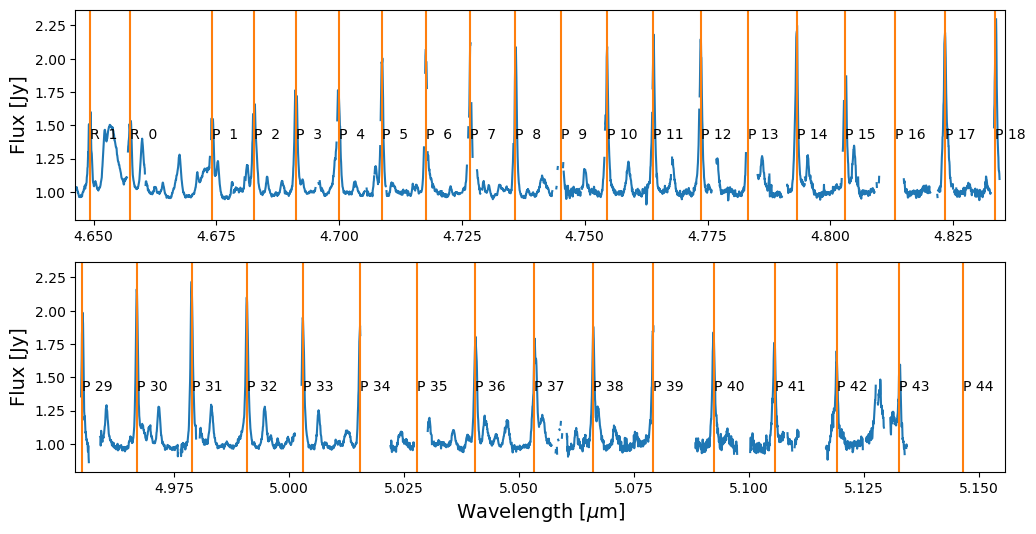

In [2]:
fig=plt.figure(figsize=(12,6))

line_ids = []

ax1=fig.add_subplot(211)
ax1.plot(wl,flux)
ax1.set_xlim(wl_min,w_min_inter)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>wl_min) & (mywave<w_min_inter) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
        line_ids.append(i)
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wl,flux)
ax2.set_xlim(w_max_inter,wl_max)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>w_max_inter) & (mywave<wl_max) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
        line_ids.append(i)
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

Not enough data near  5.160454273223877  microns. Skipping.
Not enough data near  5.146536350250244  microns. Skipping.
Starting params: 0.1 5.132768630981445 0.0002908260149844752 1.0
Fit params: 0.47410976692092927 5.132829626286654 0.00021907686156205514 1.1198026188514951


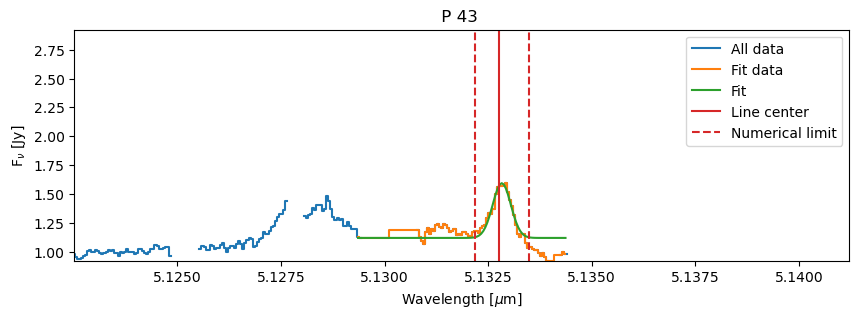

Starting params: 0.1 5.119149684906006 0.0002900543566261573 1.0
Fit params: 0.5311058369914508 5.119062657792605 0.0004030901460139872 1.0108438496100782


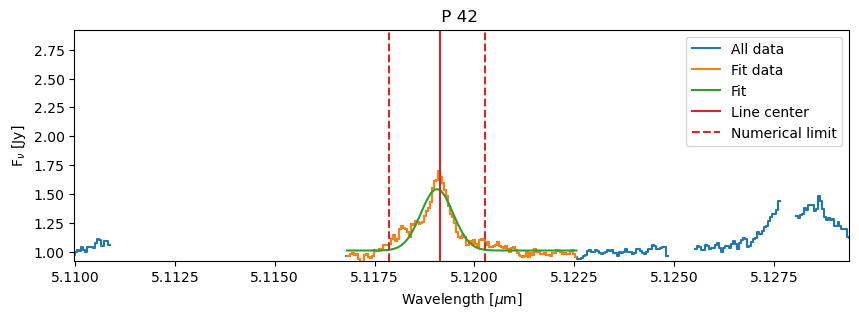

Starting params: 0.1 5.105678558349609 0.00028929107381810306 1.0
Fit params: 0.7047856233473329 5.1055721764239115 0.0003242831864882094 1.0124013447445142


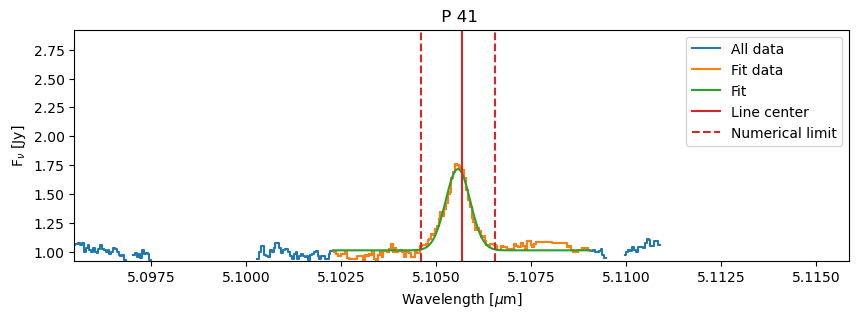

Starting params: 0.1 5.092352867126465 0.000288536031470792 1.0
Fit params: 0.7669831404039226 5.092353693101506 0.00030877492554741377 1.0156593321541643


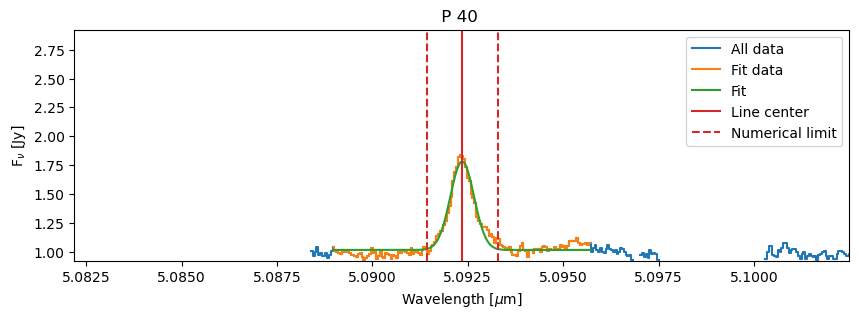

Starting params: 0.1 5.079172134399414 0.0002877892025663201 1.0
Fit params: 0.9698060566802791 5.0794168120312015 0.00041702665131615994 1.0188446052769589


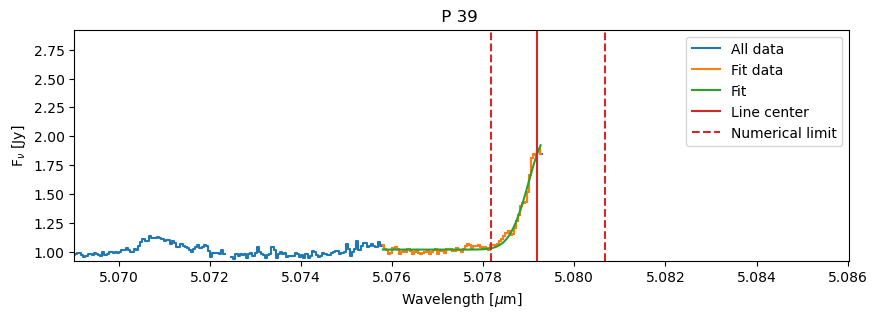

Starting params: 0.1 5.066134452819824 0.00028705047903307103 1.0
Fit params: 0.7478792547687534 5.066206383908193 0.00029113970600344 1.0376493826780782


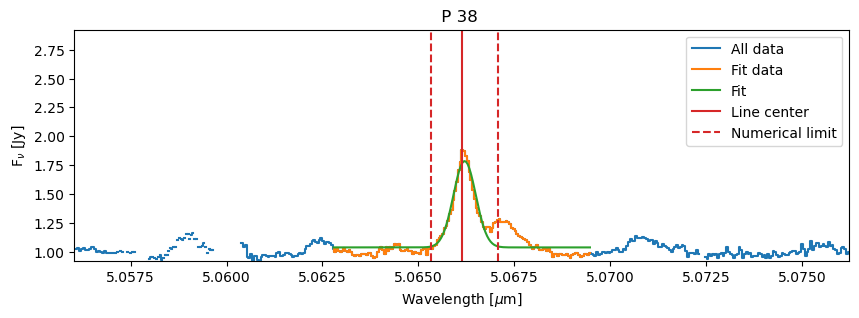

Starting params: 0.1 5.053239345550537 0.0002863198338531407 1.0
Fit params: 0.6692244690517059 5.053534332767017 0.0003948884652608344 1.0363421823548222


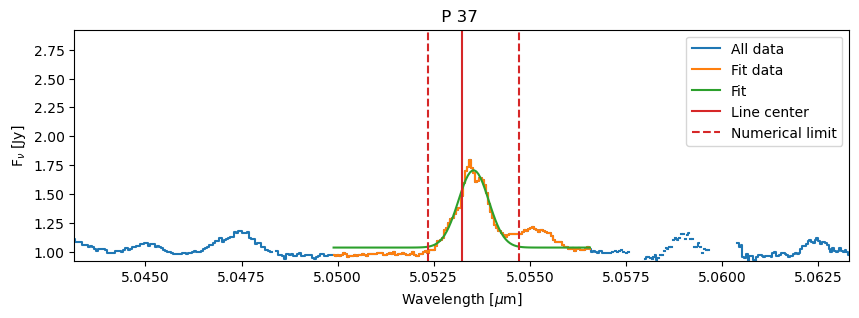

Starting params: 0.1 5.040484428405762 0.00028559713193700875 1.0
Fit params: 0.7506597853859596 5.040580611412706 0.00029959526969065104 1.041987852349681


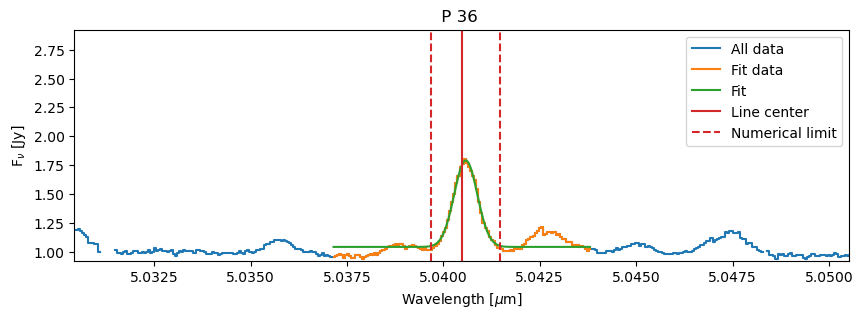

Starting params: 0.1 5.02786922454834 0.00028488234626677114 1.0
Error - curve_fit failed


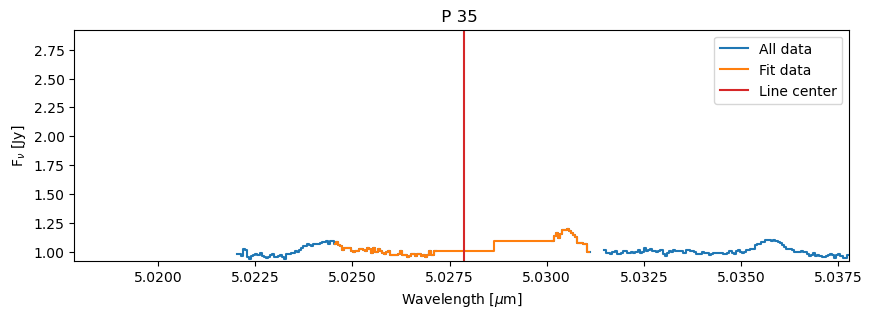

Starting params: 0.1 5.015391826629639 0.00028417536877081153 1.0
Fit params: 0.8272404763064046 5.015423241518983 0.00025615114858966204 1.0368992120826872


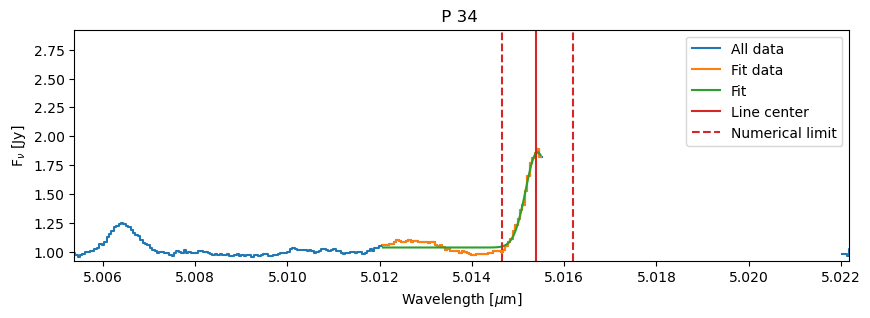

Starting params: 0.1 5.003051280975342 0.0002834761454133217 1.0
Fit params: 0.8806970195762442 5.003025549883107 0.0002773999491957112 1.025787217642972


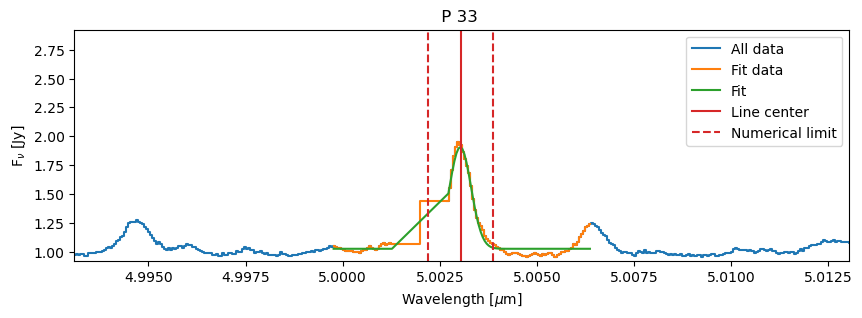

Starting params: 0.1 4.990846633911133 0.0002827846221584936 1.0
Fit params: 1.0114327515179486 4.99082394932136 0.000309454002259396 1.014056201854758


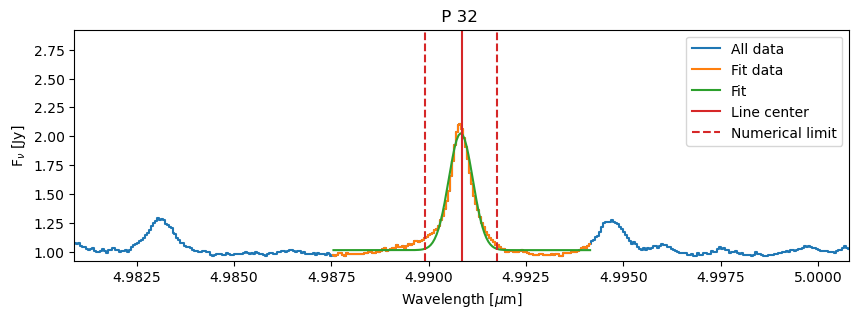

Starting params: 0.1 4.978776931762695 0.00028210074497051906 1.0
Fit params: 1.1286506793921482 4.978807881582674 0.00028164155884563563 1.0151844354719937


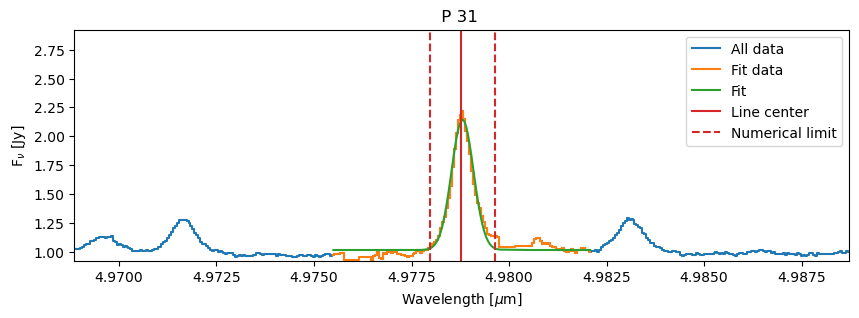

Starting params: 0.1 4.9668402671813965 0.0002814244057777817 1.0
Fit params: 1.0620623050029308 4.966877390190407 0.00024629550371272165 1.0445592149075853


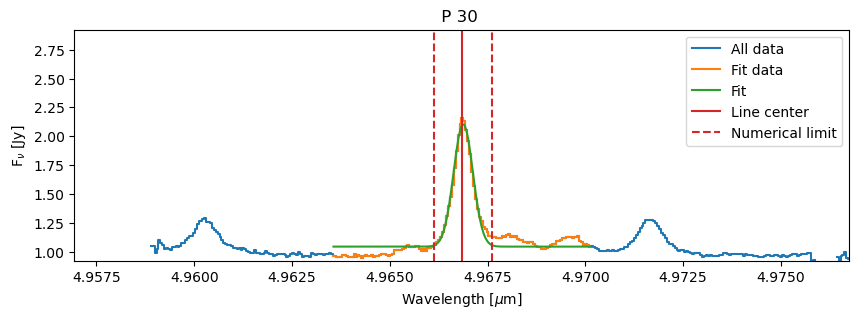

Starting params: 0.1 4.955036163330078 0.0002807555775623775 1.0
Fit params: 0.948882361830381 4.955072673344342 0.00022847672494701618 1.0105960750502563


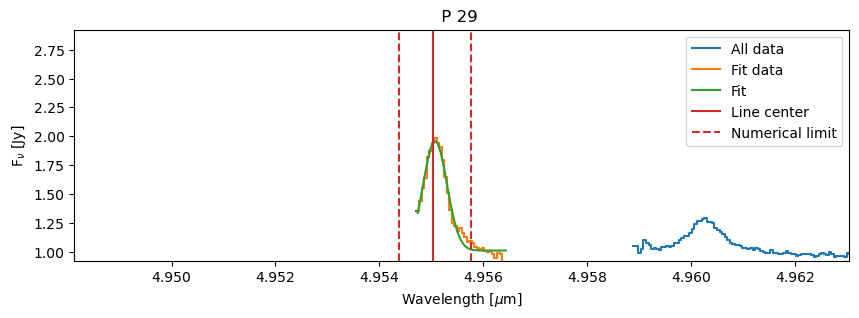

Not enough data near  4.943362712860107  microns. Skipping.
Not enough data near  4.931819438934326  microns. Skipping.
Not enough data near  4.920405387878418  microns. Skipping.
Not enough data near  4.909119129180908  microns. Skipping.
Not enough data near  4.8979597091674805  microns. Skipping.
Not enough data near  4.886926174163818  microns. Skipping.
Not enough data near  4.876017093658447  microns. Skipping.
Not enough data near  4.865231990814209  microns. Skipping.
Not enough data near  4.854569911956787  microns. Skipping.
Not enough data near  4.844029426574707  microns. Skipping.
Starting params: 0.1 4.833610534667969 0.0002738755223252036 1.0
Fit params: 1.1771407196832837 4.8336934030038545 0.00025756266010201626 1.024137749884602


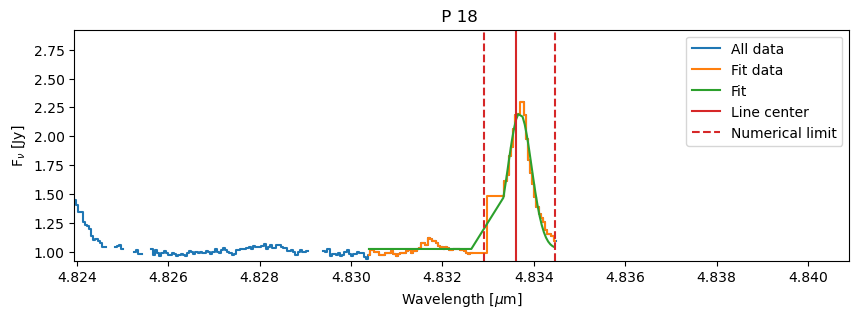

Starting params: 0.1 4.823310852050781 0.0002732919355971596 1.0
Fit params: 1.028109330002683 4.8233796690483235 0.00038561220792843973 1.01320057937119


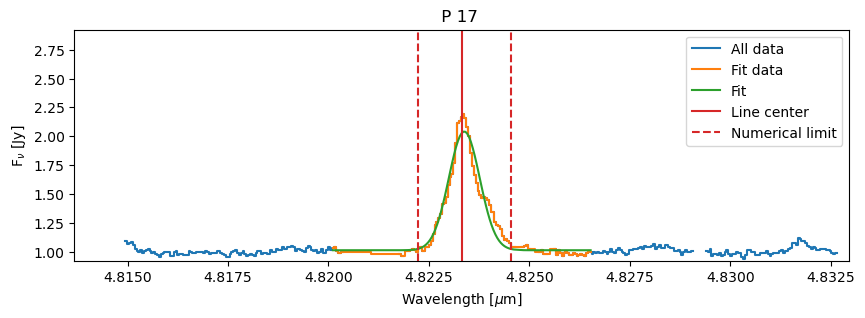

Starting params: 0.1 4.813130855560303 0.00027271513036303865 1.0
Fit params: 0.1 328963.36746752093 0.00027271513036303865 1.0106097662059024


/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/flux_calculator/helpers.py:150: OptimizeWarning: Covariance of the parameters could not be estimated
/opt/anaconda3/lib/python3.12/site-packages/spectools_ir-1.0.1-py3.12.egg/spectools_ir/flux_calculator/helpers.py:188: RuntimeWarning: Mean of empty slice


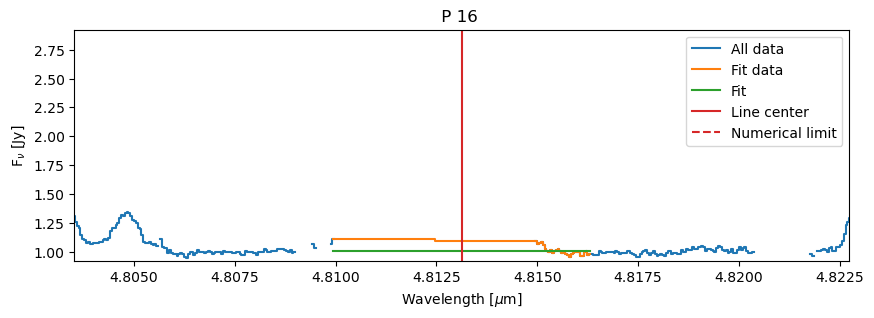

Starting params: 0.1 4.803069114685059 0.00027214502556912863 1.0
Fit params: 0.9503958054030278 4.803037962339594 0.00027613198714002146 1.0727178312574548


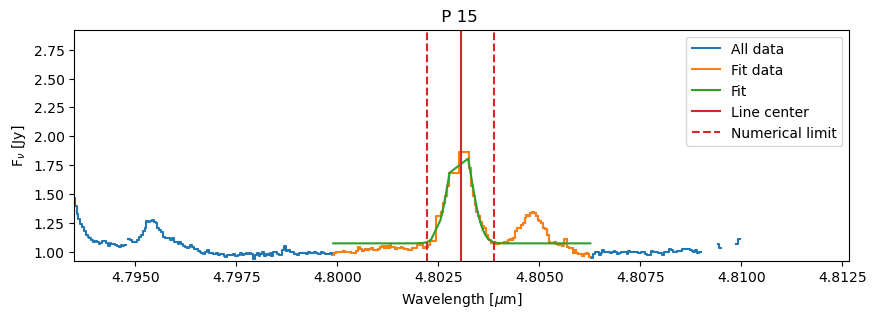

Starting params: 0.1 4.793123722076416 0.00027158151314381315 1.0
Fit params: 1.0825654844372024 4.793137970755105 0.0002570158143869169 1.0795371374636014


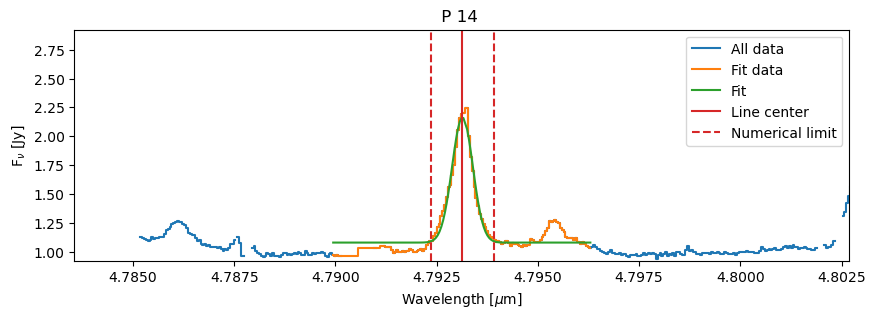

Starting params: 0.1 4.78329610824585 0.00027102467414080446 1.0
Fit params: -0.21269771987707198 4.781098680242112 -0.0011852391551337937 1.173602315291636


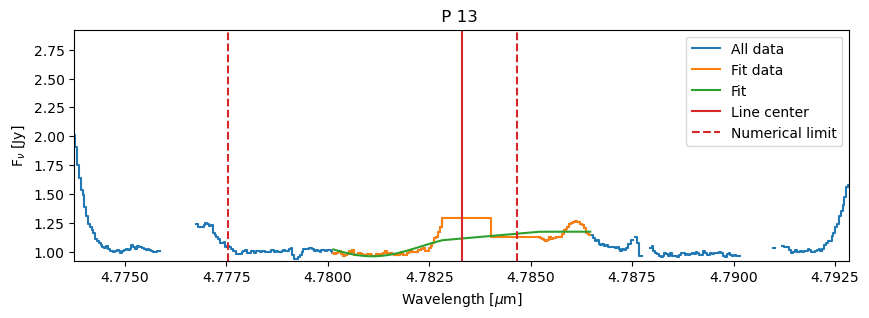

Starting params: 0.1 4.77358341217041 0.0002704743464526781 1.0
Fit params: 1.051238743329195 4.773616679712919 0.0002941733046099349 1.0152005523567726


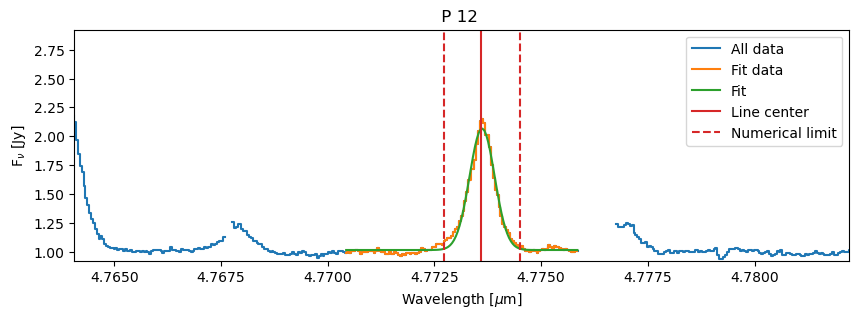

Starting params: 0.1 4.763985633850098 0.00026993053007943416 1.0
Fit params: 1.044817978738412 4.764006437517418 0.00028511409843326967 1.0118758301304798


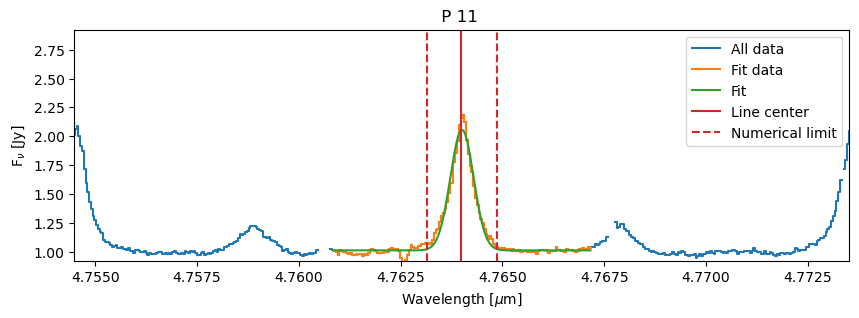

Starting params: 0.1 4.754501819610596 0.0002693931709852643 1.0
Fit params: 0.9252242907708712 4.754535406754977 0.00030664327366227193 1.0007797785396504


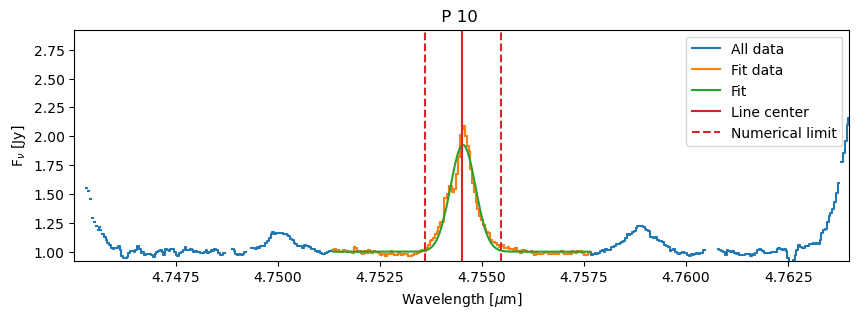

Starting params: 0.1 4.745131015777588 0.00026886221513436055 1.0
Fit params: 0.7053558850126038 4.745068227822087 0.0003433552429505556 1.001611579896609


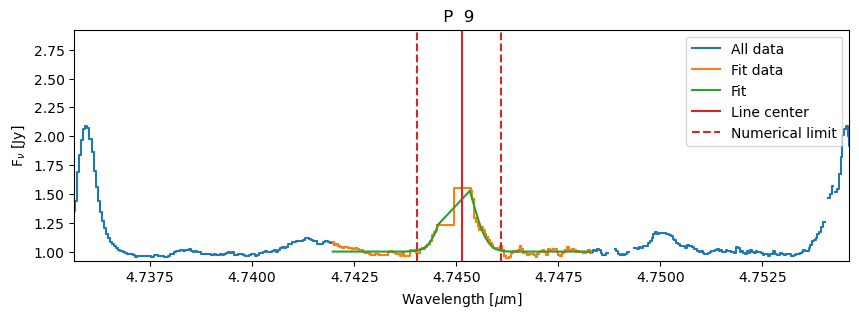

Starting params: 0.1 4.735873222351074 0.00026833766252672283 1.0
Fit params: 1.0187876218372887 4.7359386311018685 0.0002493046941024668 1.0060714639408173


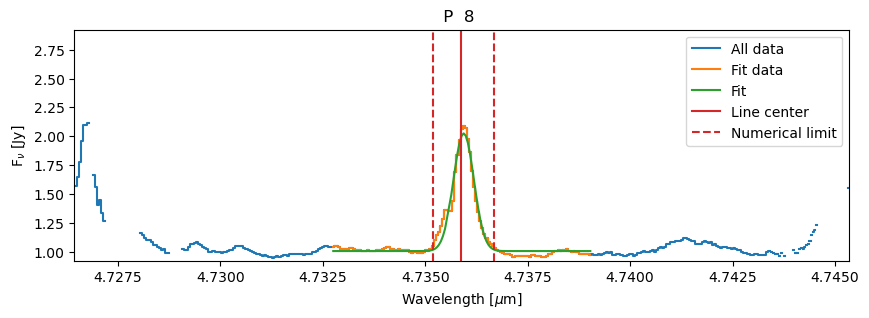

Starting params: 0.1 4.72672700881958 0.0002678194321086389 1.0
Fit params: 0.9735688222068346 4.726700619413999 0.0002690635869505653 1.0290102958211387


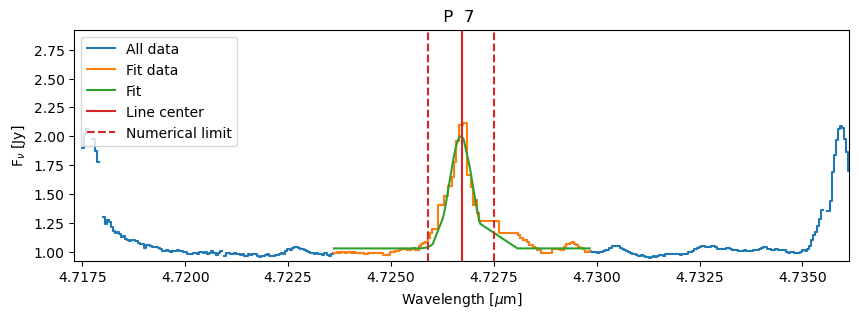

Starting params: 0.1 4.717691421508789 0.00026730746984430067 1.0
Fit params: 1.0201825139216234 4.717661412040454 0.0002635323048837779 1.0255740843710328


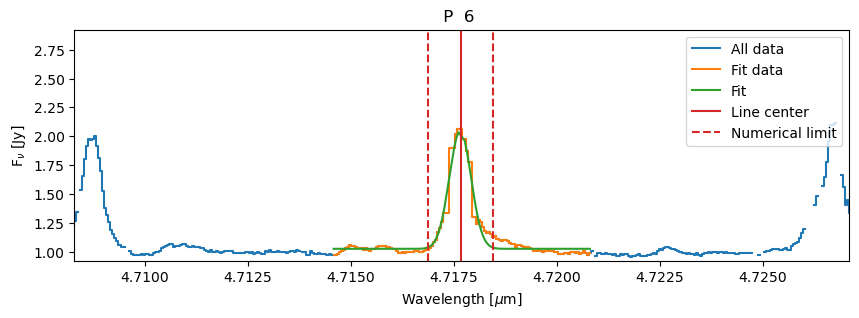

Starting params: 0.1 4.708765983581543 0.000266801748715804 1.0
Fit params: 0.9727961218663027 4.708723118521744 0.00024637896800270344 1.0323683126438343


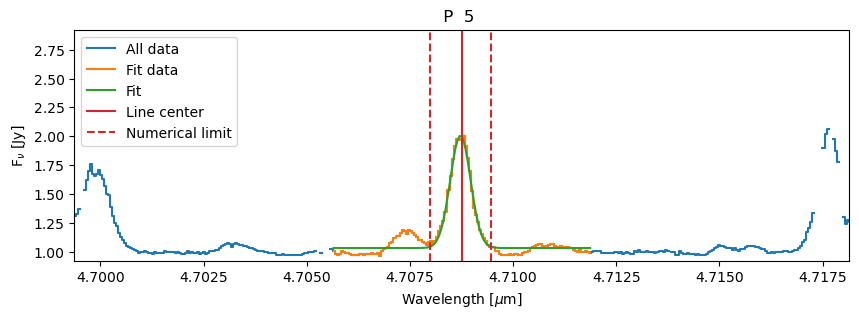

Starting params: 0.1 4.699949741363525 0.0002663022146873407 1.0
Fit params: 0.6841696399473296 4.699817064496393 0.0004054245682942635 1.0043304747822068


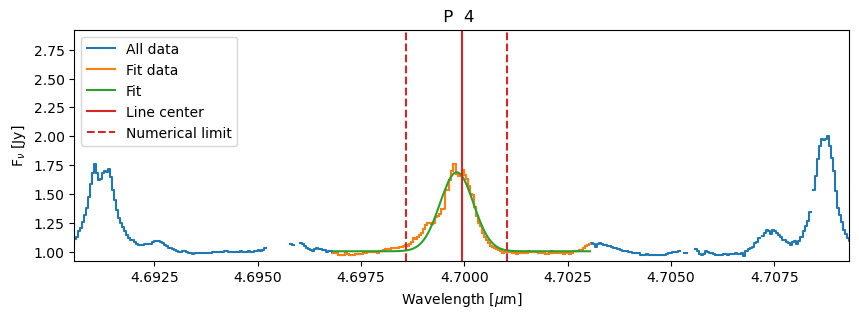

Starting params: 0.1 4.691242218017578 0.00026580884074100684 1.0
Fit params: 0.7157878632087789 4.691220195778243 0.0003232379020938252 1.017971815199065


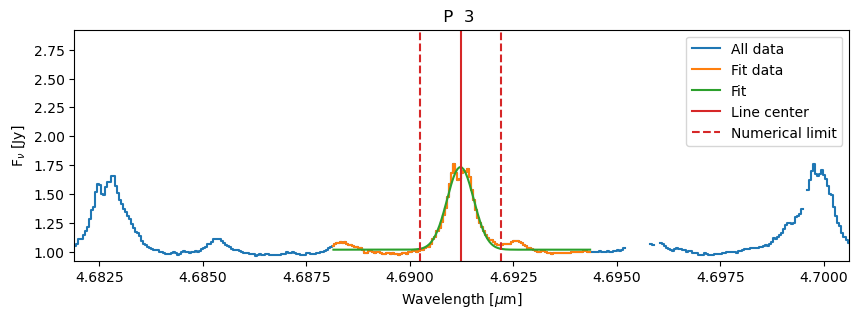

Starting params: 0.1 4.682642936706543 0.00026532159985889823 1.0
Fit params: 0.5767913511201685 4.682742227947952 0.00035375714921019423 1.0457483501475147


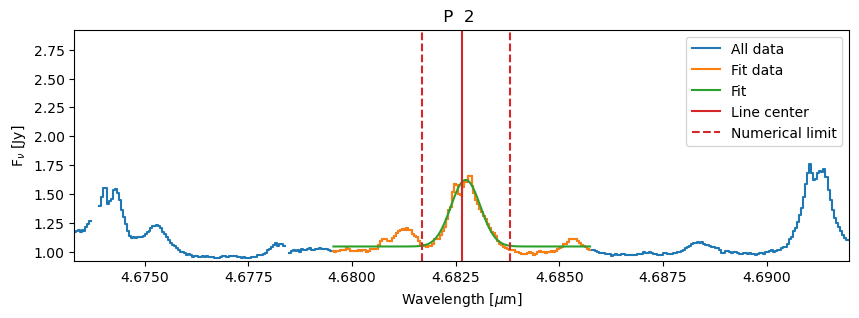

Starting params: 0.1 4.6741509437561035 0.0002648404380052067 1.0
Fit params: 0.42186875827709736 4.67410594685086 0.0003795915372457273 1.0764563717534492


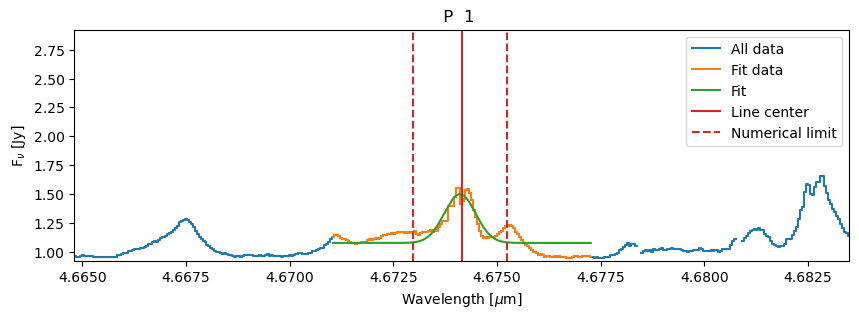

Starting params: 0.1 4.6574859619140625 0.0002638961892756507 1.0
Fit params: 0.37439324658377804 4.657440814669841 0.0002601996783903384 1.157757375663649


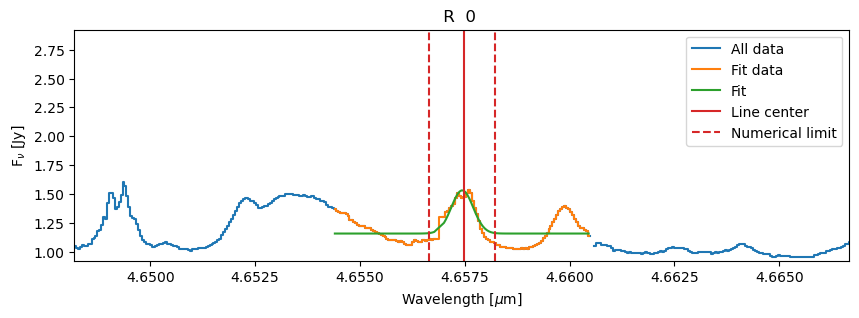

Starting params: 0.1 4.6493120193481445 0.00026343304836397795 1.0
Fit params: 0.44662958316451934 4.64926450609028 0.00028633216526521133 1.0723788140632877


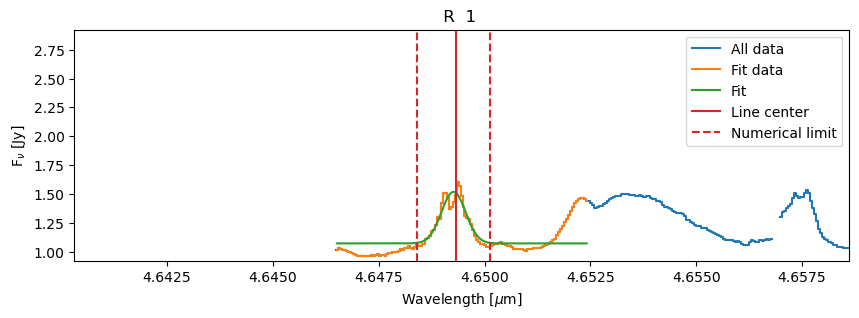

Not enough data near  4.641242027282715  microns. Skipping.
Not enough data near  4.633276462554932  microns. Skipping.


In [3]:
# run slabspec normally, without assessing fits; might be a useful point of comparison
lineflux_data = calc_fluxes(wl,flux,hitran_data, fwhm_v=40., sep_v=200.,cont=1.,verbose=True,vet_fits=False,
                plot=True,v_dop=0,amp=0.1,ymin=None,ymax=None,bounds=None)

     P 45      
Not enough data near  5.160454273223877  microns. Skipping.
     P 44      
Not enough data near  5.146536350250244  microns. Skipping.
     P 43      
Starting params: 0.1 5.132768630981445 0.0002908260149844752 1.05
0 27
Fit params: 0.4741097682247407 5.132829626286889 0.00021907686215421877 1.11980261843722


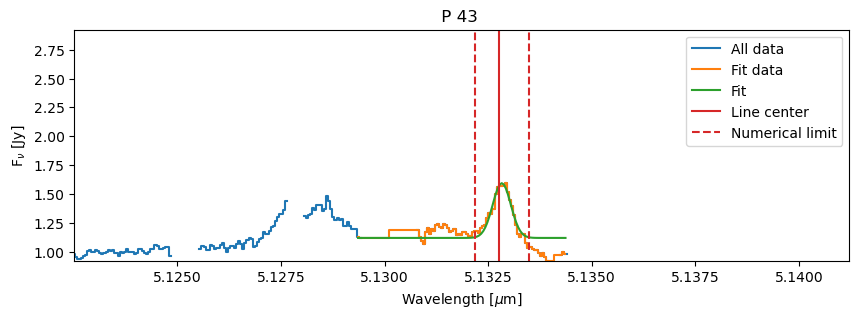

     P 42      
Starting params: 0.1 5.119149684906006 0.0002900543566261573 1.05
11 46
Fit params: 0.5311058372553581 5.119062657792561 0.000403090144474959 1.0108438499471433


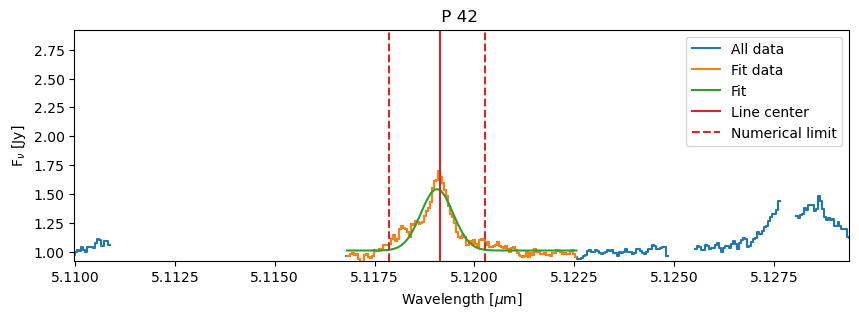

     P 41      
Starting params: 0.1 5.105678558349609 0.00028929107381810306 1.05
0 48
Fit params: 0.7047865406654721 5.105572176720152 0.00032428206891709996 1.012401554645411


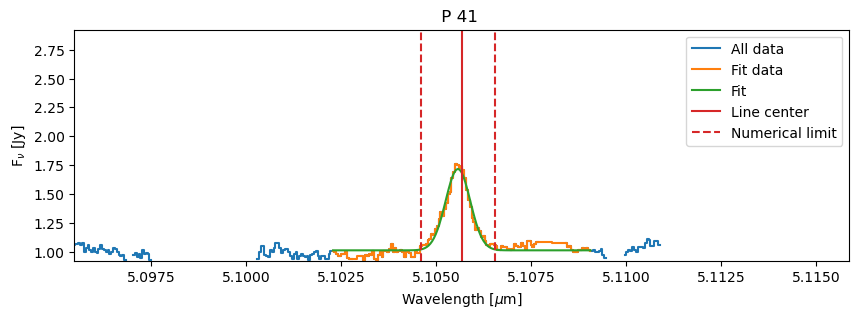

     P 40      
Starting params: 0.1 5.092352867126465 0.000288536031470792 1.05
0 54
Fit params: 0.7669831416078118 5.0923536931015665 0.00030877492488094895 1.015659332205803


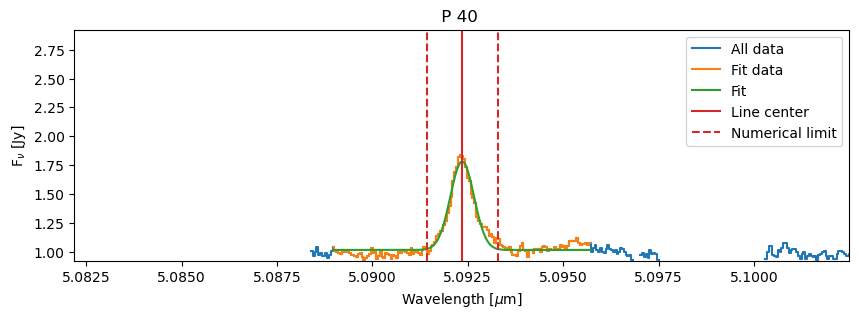

     P 39      
Starting params: 0.1 5.079172134399414 0.0002877892025663201 1.05
0 34
Fit params: 0.9698059862199525 5.0794168119546725 0.0004170266097215867 1.0188446073058137


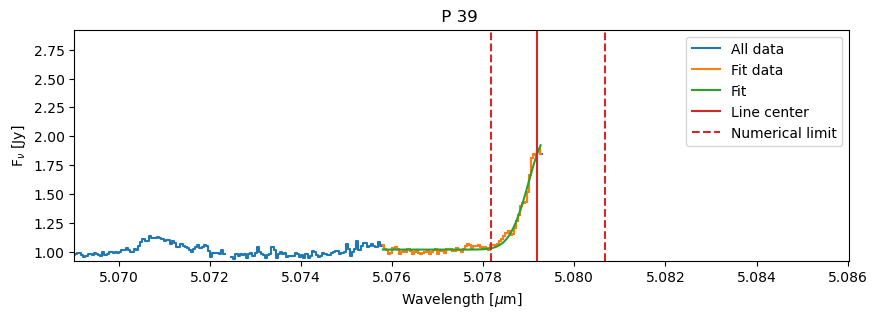

     P 38      
Starting params: 0.1 5.066134452819824 0.00028705047903307103 1.05
0 51
Fit params: 0.7478865942138563 5.0662063815910745 0.000291132729838344 1.037650530011624


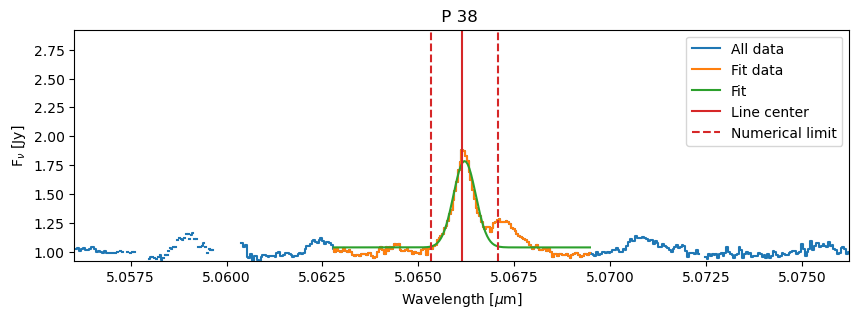

     P 37      
Starting params: 0.1 5.053239345550537 0.0002863198338531407 1.05
0 54
Fit params: 0.6692233116881788 5.053534333508595 0.0003948903213251702 1.036341889674021


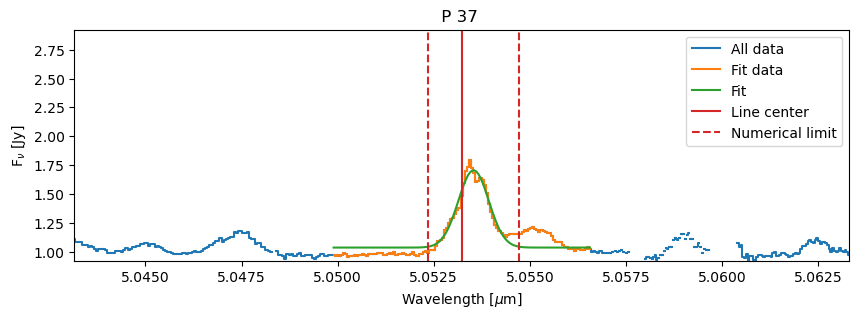

     P 36      
Starting params: 0.1 5.040484428405762 0.00028559713193700875 1.05
0 44
Fit params: 0.7506596442970817 5.040580611406263 0.0002995954085595184 1.0419878291707225


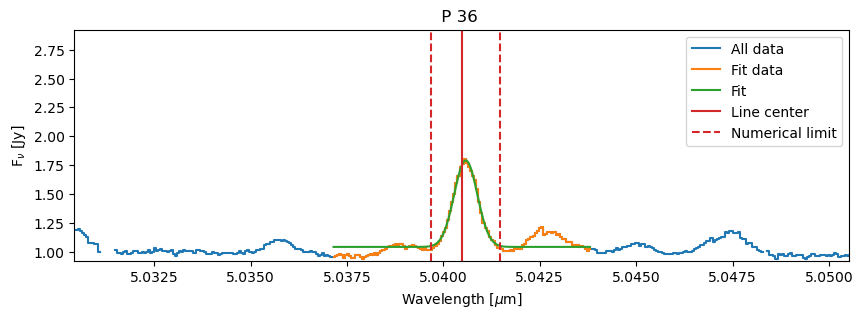

     P 35      
Starting params: 0.1 5.02786922454834 0.00028488234626677114 1.05
Error - curve_fit failed
!! Curve fit failed !!


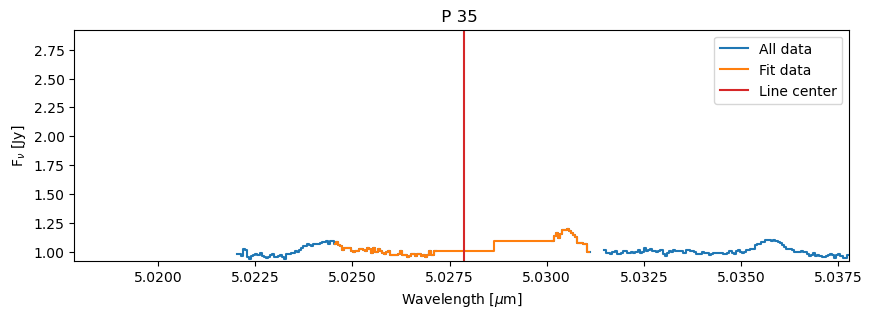

     P 34      
Starting params: 0.1 5.015391826629639 0.00028417536877081153 1.05
0 9
Fit params: 0.8272408512006257 5.015423243453796 0.0002561528329411424 1.0368990915993745


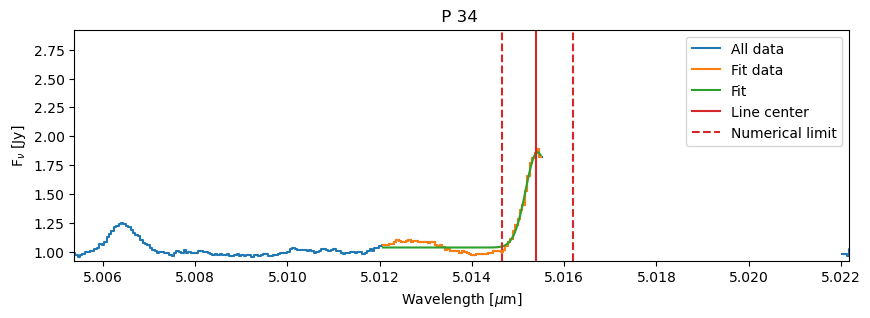

     P 33      
Starting params: 0.1 5.003051280975342 0.0002834761454133217 1.05
12 19
Fit params: 0.8806970197057047 5.003025549883143 0.0002773999491503515 1.0257872176307474


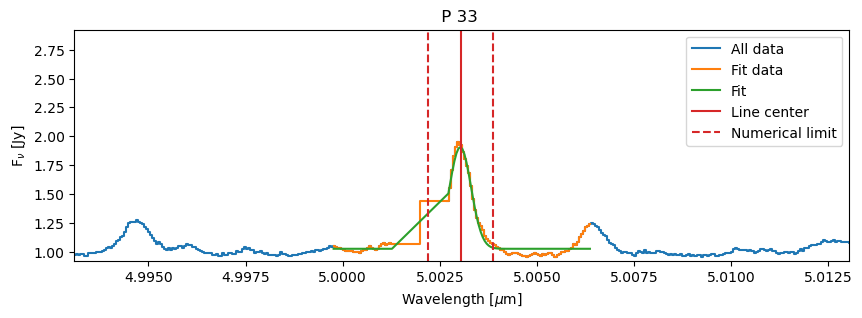

     P 32      
Starting params: 0.1 4.990846633911133 0.0002827846221584936 1.05
0 51
Fit params: 1.0114327516167048 4.990823949321358 0.0003094540021136183 1.0140562018544568


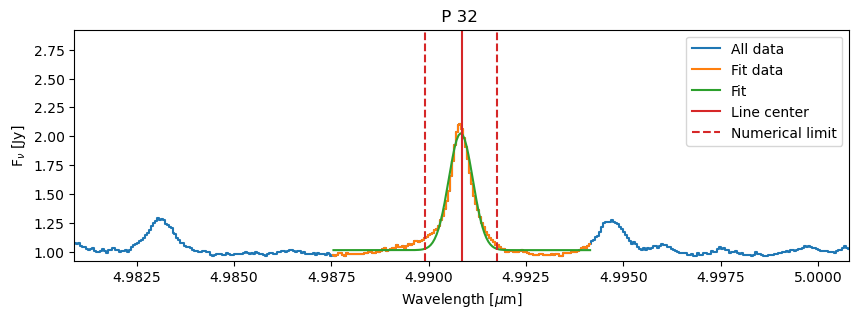

     P 31      
Starting params: 0.1 4.978776931762695 0.00028210074497051906 1.05
0 44
Fit params: 1.1286506794480469 4.978807881582679 0.00028164155862942696 1.0151844355175732


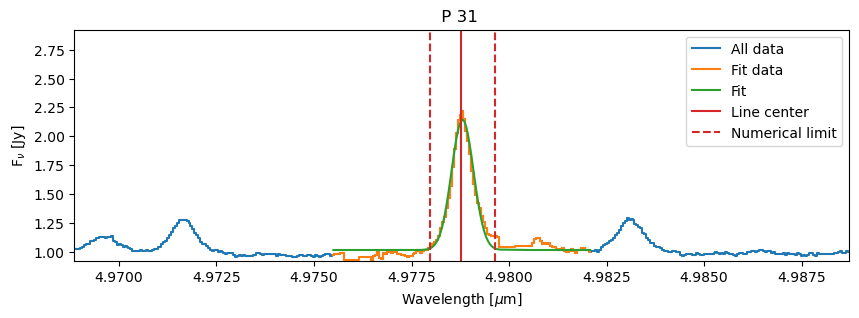

     P 30      
Starting params: 0.1 4.9668402671813965 0.0002814244057777817 1.05
0 41
Fit params: 1.0620641381398253 4.9668773898800245 0.0002462945014952551 1.0445594473240818


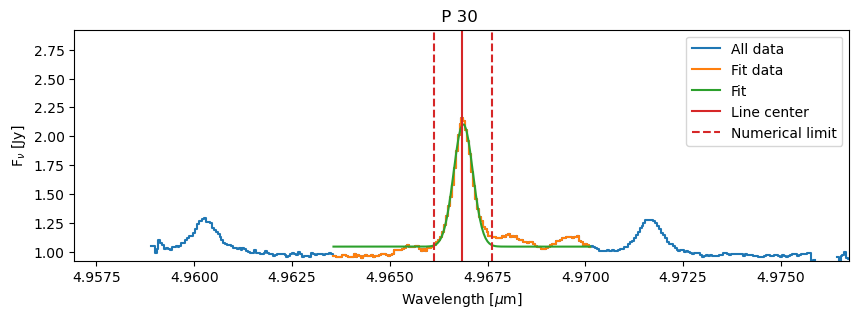

     P 29      
Starting params: 0.1 4.955036163330078 0.0002807555775623775 1.05
9 7
! negative/flat fit ! rejecting...
!! Curve fit failed !!


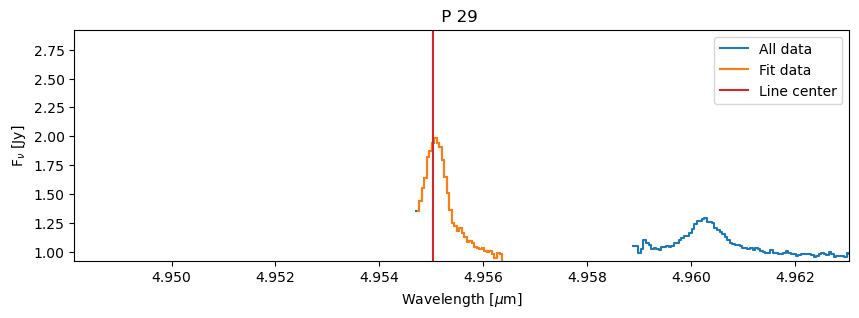

     P 28      
Not enough data near  4.943362712860107  microns. Skipping.
     P 27      
Not enough data near  4.931819438934326  microns. Skipping.
     P 26      
Not enough data near  4.920405387878418  microns. Skipping.
     P 25      
Not enough data near  4.909119129180908  microns. Skipping.
     P 24      
Not enough data near  4.8979597091674805  microns. Skipping.
     P 23      
Not enough data near  4.886926174163818  microns. Skipping.
     P 22      
Not enough data near  4.876017093658447  microns. Skipping.
     P 21      
Not enough data near  4.865231990814209  microns. Skipping.
     P 20      
Not enough data near  4.854569911956787  microns. Skipping.
     P 19      
Not enough data near  4.844029426574707  microns. Skipping.
     P 18      
Starting params: 0.1 4.833610534667969 0.0002738755223252036 1.05
0 11
Fit params: 1.1771523979706313 4.833693402600273 0.0002575564013993039 1.024139810435095


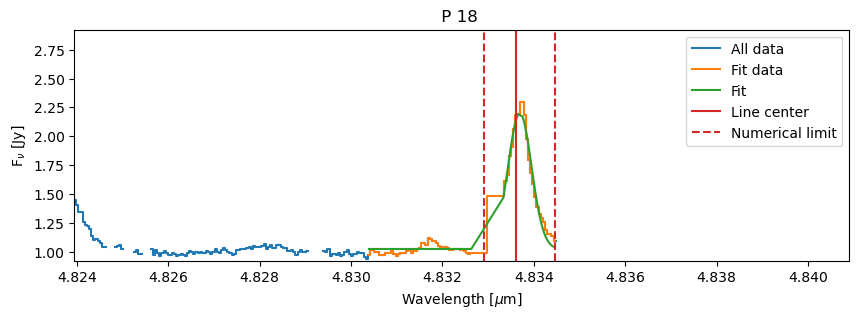

     P 17      
Starting params: 0.1 4.823310852050781 0.0002732919355971596 1.05
6 39
Fit params: 1.0281059746779673 4.8233796711349335 0.00038561676811200497 1.0131986511231583


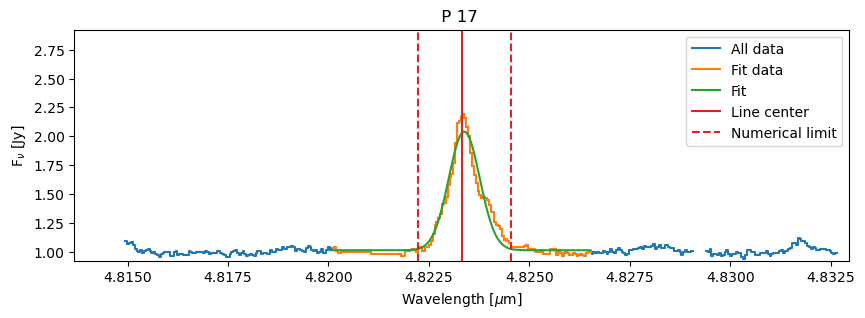

     P 16      
Starting params: 0.1 4.813130855560303 0.00027271513036303865 1.05
0 0
! negative/flat fit ! rejecting...
!! Curve fit failed !!


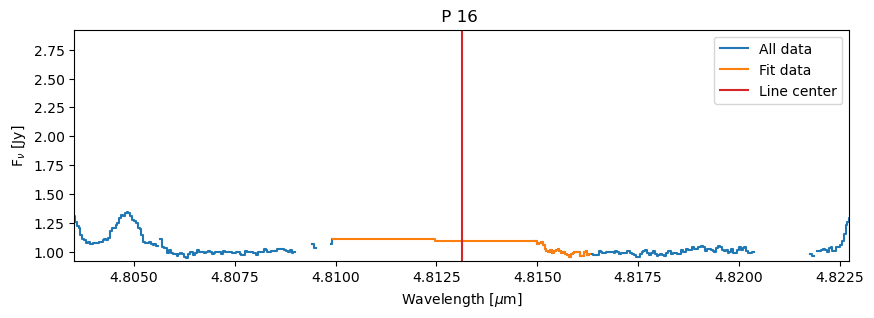

     P 15      
Starting params: 0.1 4.803069114685059 0.00027214502556912863 1.05
2 41
Fit params: 0.95039597687264 4.803037962353291 0.0002761319430454518 1.072717836165911


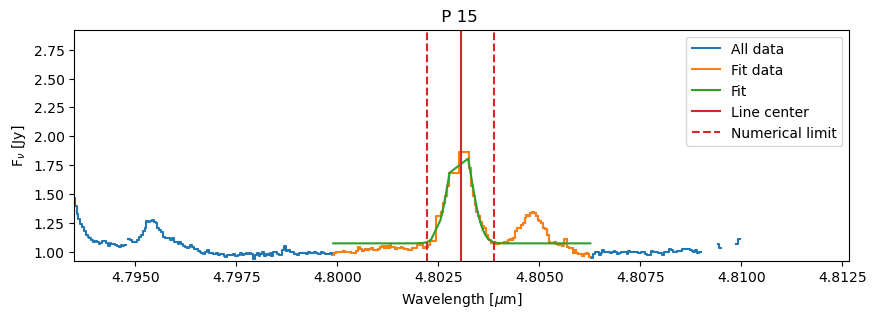

     P 14      
Starting params: 0.1 4.793123722076416 0.00027158151314381315 1.05
7 45
Fit params: 1.082565484262198 4.793137970755065 0.00025701581432233486 1.079537137438348


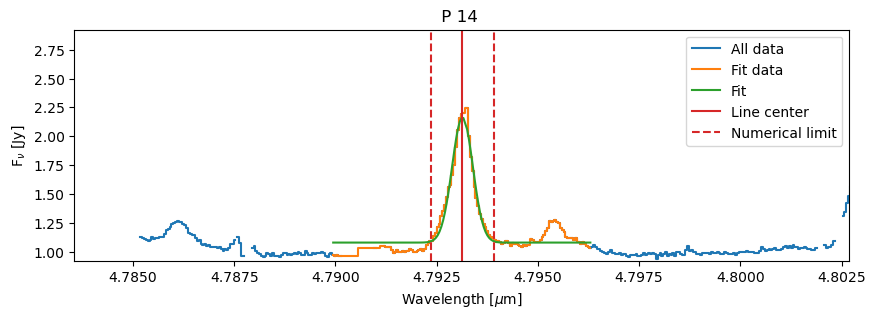

     P 13      
Starting params: 0.1 4.78329610824585 0.00027102467414080446 1.05
22 21
! negative/flat fit ! rejecting...
!! Curve fit failed !!


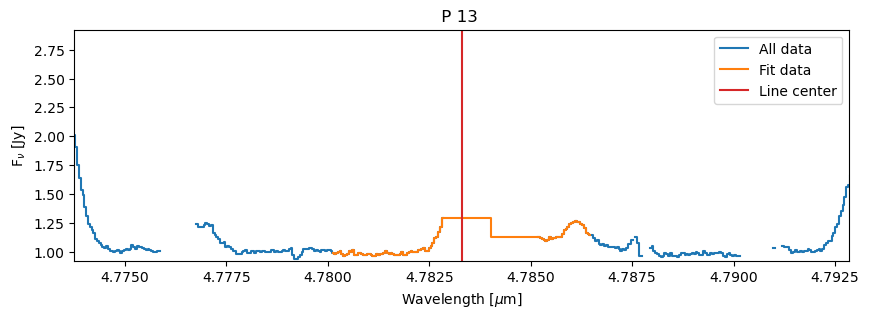

     P 12      
Starting params: 0.1 4.77358341217041 0.0002704743464526781 1.05
0 45
Fit params: 1.0512318124381186 4.773616678080253 0.0002941786869649077 1.015198950882238


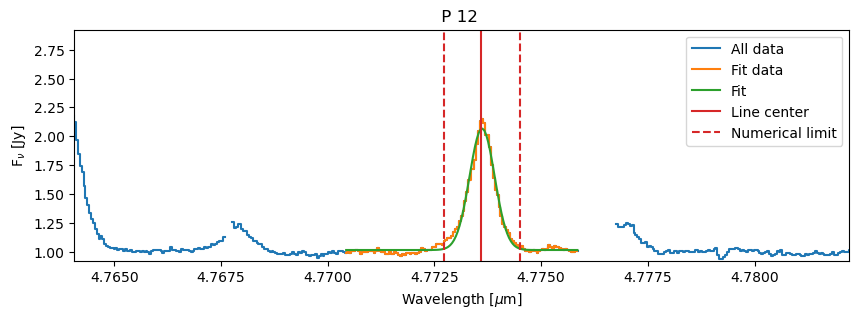

     P 11      
Starting params: 0.1 4.763985633850098 0.00026993053007943416 1.05
0 54
Fit params: 1.0448179785996559 4.764006437517418 0.00028511409879800867 1.0118758300402422


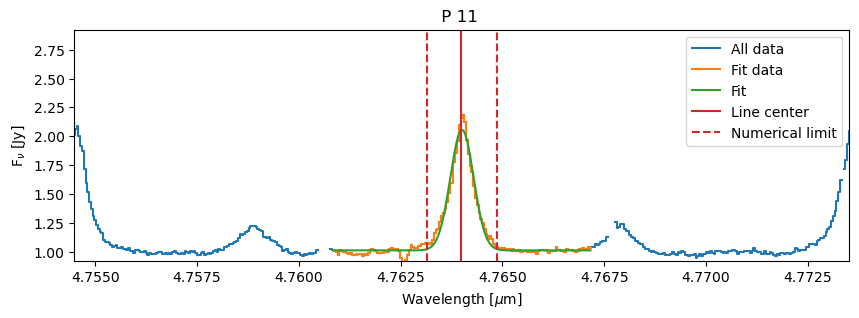

     P 10      
Starting params: 0.1 4.754501819610596 0.0002693931709852643 1.05
0 57
Fit params: 0.9252243479587107 4.754535406775212 0.0003066432202813417 1.0007797890311374


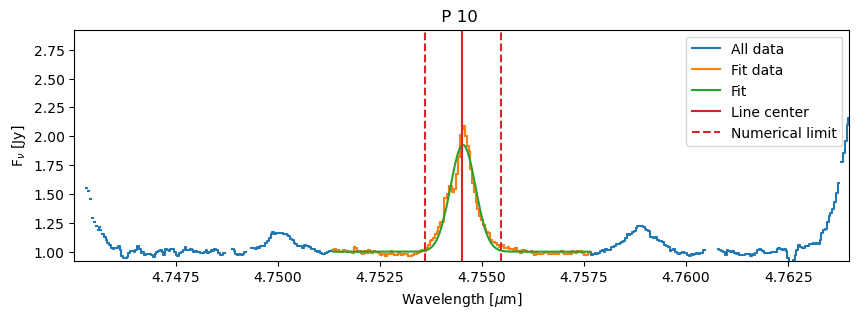

     P  9      
Starting params: 0.1 4.745131015777588 0.00026886221513436055 1.05
7 48
Fit params: 0.7053614769551616 4.7450682268525775 0.00034335375681396704 1.0016117147751749


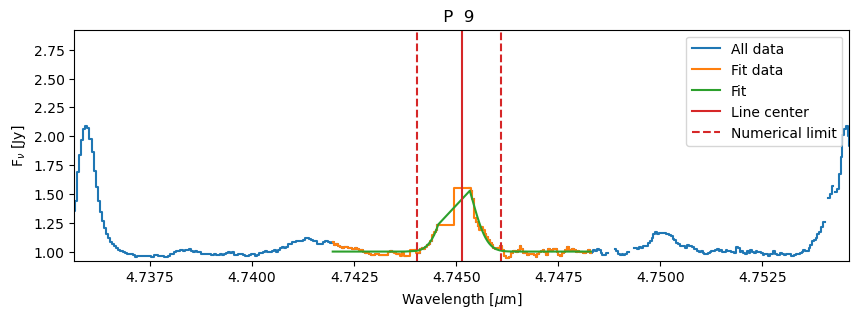

     P  8      
Starting params: 0.1 4.735873222351074 0.00026833766252672283 1.05
0 39
Fit params: 1.0188182414461562 4.735938639158303 0.0002492847405528114 1.0060755258765803


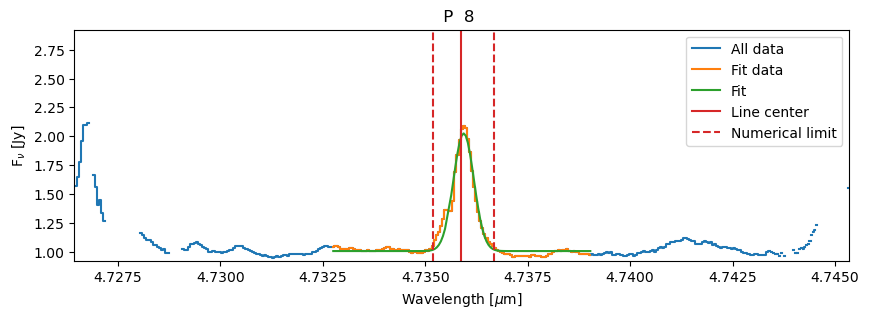

     P  7      
Starting params: 0.1 4.72672700881958 0.0002678194321086389 1.05
0 27
Fit params: 0.9735688212204895 4.726700619413811 0.00026906358726460304 1.0290102957484948


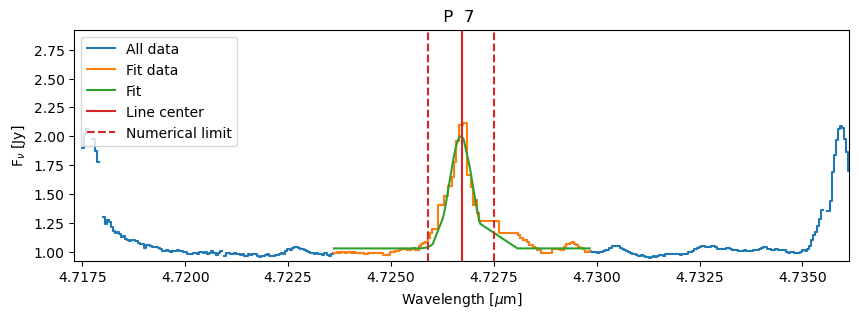

     P  6      
Starting params: 0.1 4.717691421508789 0.00026730746984430067 1.05
0 41
Fit params: 1.0201781866529258 4.717661413063626 0.0002635348144588312 1.0255735486172628


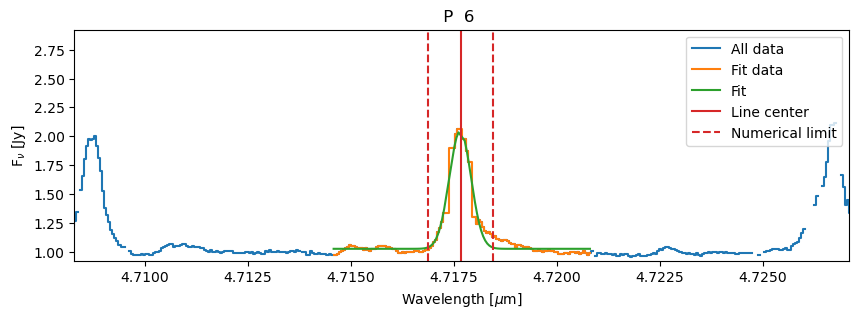

     P  5      
Starting params: 0.1 4.708765983581543 0.000266801748715804 1.05
0 40
Fit params: 0.9727971876555209 4.7087231188319025 0.0002463782662153261 1.0323684667823494


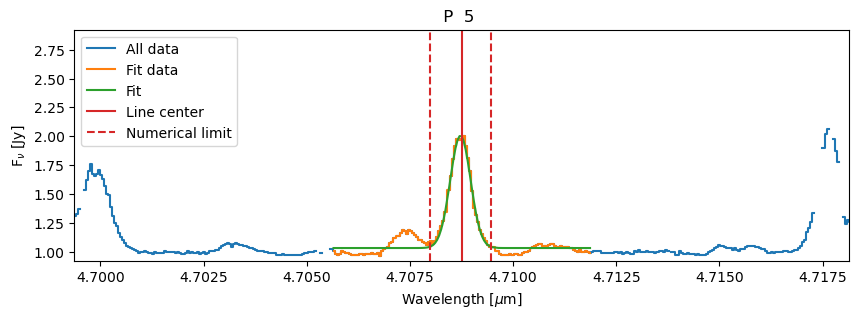

     P  4      
Starting params: 0.1 4.699949741363525 0.0002663022146873407 1.05
1 60
Fit params: 0.6841692910907389 4.6998170642435415 0.0004054251999460848 1.0043303618163586


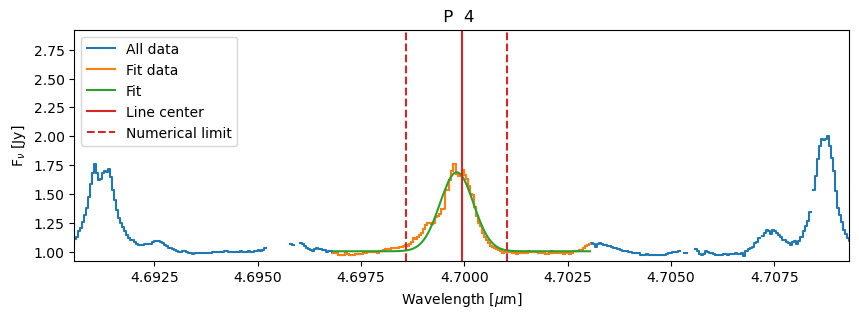

     P  3      
Starting params: 0.1 4.691242218017578 0.00026580884074100684 1.05
0 56
Fit params: 0.7157875874406608 4.691220195563559 0.00032323822314236434 1.0179717587432566


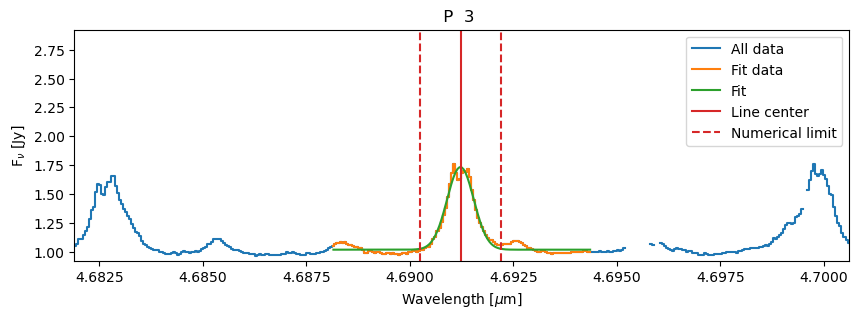

     P  2      
Starting params: 0.1 4.682642936706543 0.00026532159985889823 1.05
0 58
Fit params: 0.5767914303642185 4.682742228004982 0.00035375702061963345 1.0457483691375995


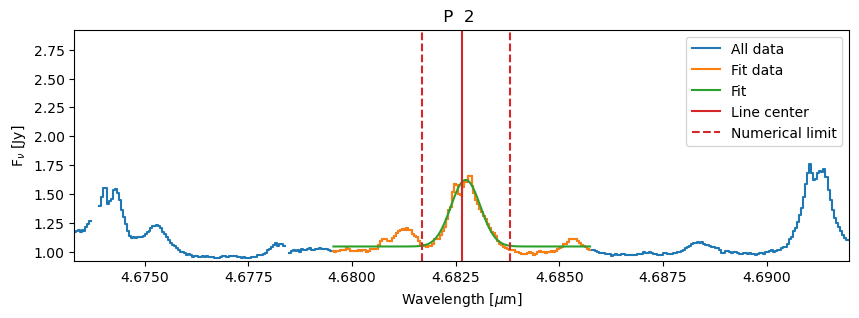

     P  1      
Starting params: 0.1 4.6741509437561035 0.0002648404380052067 1.05
0 62
Fit params: 0.4218687578970087 4.674105946851369 0.0003795915351043648 1.0764563721341216


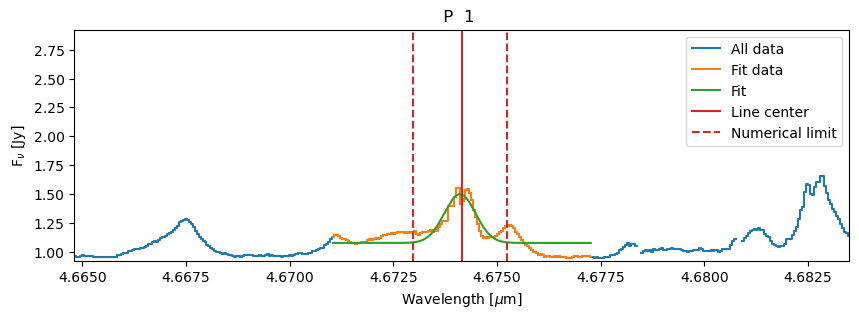

     R  0      
Starting params: 0.1 4.6574859619140625 0.0002638961892756507 1.05
0 43
Fit params: 0.3743932437080005 4.657440814670615 0.0002601996823992154 1.1577573754067794


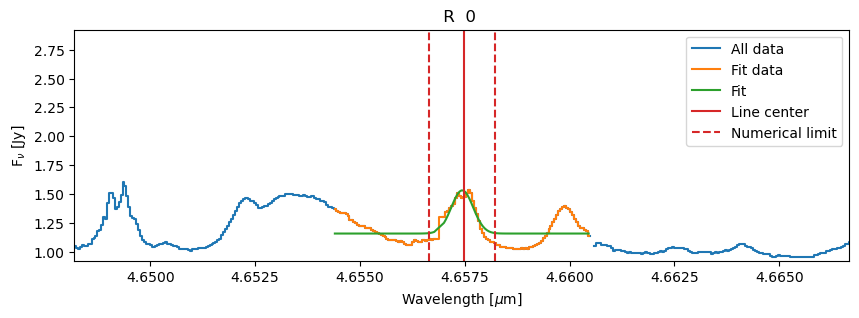

     R  1      
Starting params: 0.1 4.6493120193481445 0.00026343304836397795 1.05
2 53
Fit params: 0.4466295834481355 4.649264506090317 0.0002863321654410707 1.072378814007903


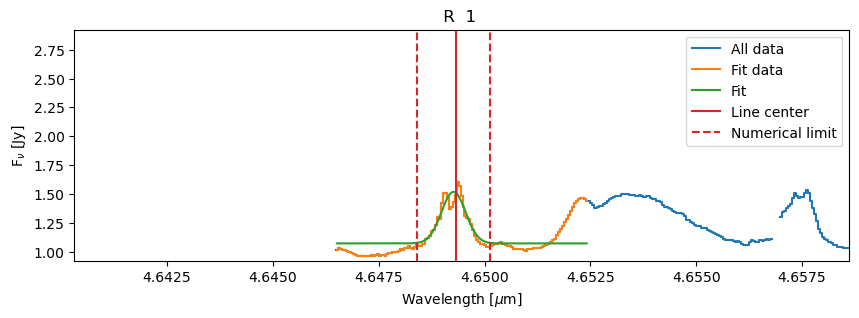

     R  2      
Not enough data near  4.641242027282715  microns. Skipping.
     R  3      
Not enough data near  4.633276462554932  microns. Skipping.


In [4]:
# run calc_fluxes() manually

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape, helpers

# pulling lines from calc_fluxes() in slabspec to make the same astropy table
# based on values Colette used in exmaple notebook. maybe make these variables in the future but can probably leave them for first guesses
fwhm_v=40.
sep_v=200.
cont=np.copy(cont_jy)
verbose=True
vet_fits=False
plot=True
v_dop=0
amp=0.1
ymin=None
ymax=None
bounds=None
wave = np.copy(wl)

plot_query = 1

lineflux_data=helpers._convert_quantum_strings(hitran_data)
lineflux_data=helpers._strip_superfluous_hitran_data(lineflux_data)

nlines=np.size(lineflux_data)
#Add new columns to astropy table to hold line fluxes and error bars
lineflux_data['lineflux']=np.zeros(nlines)  
lineflux_data['lineflux_Gaussian']=np.zeros(nlines)  
lineflux_data['lineflux_err']=np.zeros(nlines)  
lineflux_data['linewidth']=np.zeros(nlines)
lineflux_data['linewidth_err']=np.zeros(nlines)
lineflux_data['v_dop_fit']=np.zeros(nlines)  
lineflux_data['v_dop_fit_err']=np.zeros(nlines)  
lineflux_data['continuum']=np.zeros(nlines)  
lineflux_data['continuum_err']=np.zeros(nlines)  
lineflux_data['wave_fit']=np.zeros(nlines)  
lineflux_data['wave_fit_err']=np.zeros(nlines)  
lineflux_data['amp_fit']=np.zeros(nlines)  
lineflux_data['amp_fit_err']=np.zeros(nlines)  
goodfit_bool=[True]*nlines

for i,w0 in enumerate(lineflux_data['wave']): 
    print(lineflux_data['Qpp_HITRAN'][i])
    # if the hitran transition is listed in the allowed transition list:
    #print(w0)
    wdop=v_dop*1e3/c.value*w0
    dw=sep_v*1e3/c.value*w0
    dw2=2*sep_v*1e3/c.value*w0
    sig_w=fwhm_to_sigma(fwhm_v*1e3/c.value*w0)
    mybool=((wave>(w0+wdop-dw)) & (wave<(w0+wdop+dw)) & np.isfinite(flux))
    myx=wave[mybool]
    myy=flux[mybool]
    if((len(myx) <= 5) & (verbose==True) ):
        print('Not enough data near ', w0+wdop, ' microns. Skipping.')
        goodfit_bool[i]=False
    if(len(myx) > 5):
        print('Starting params:',amp,w0+wdop,sig_w,cont)
        g=helpers._line_fit(np.array(myx),np.array(myy),nterms=4,p0=[amp,w0+wdop,sig_w,cont],bounds=bounds)

        if  g != -1: # check if slabspec thinks it fit. uses the gradient of the left side of the curve to determine if there is a fit
            # will be biased if there's no data on the left side of the center but data on the other side !!
            grad = np.gradient(g['yfit'][0:(int(len(g['yfit'])/2-2))])
            print(len(np.where(grad < 0)[0]), len(np.where(grad > 0)[0]))
            if len(np.where(grad < 0)[0]) >= len(np.where(grad > 0)[0]):
                print('! negative/flat fit ! rejecting...')
                g=-1 # update g

        if(g!=-1):   #curve fit succeeded

            # plot fit upclose
            #plt.plot(myx,myy)
            #plt.plot(myx,g['yfit'])
            
            p=g['parameters']
            print('Fit params:', p[0],p[1],p[2],p[3])
            perr=g['parameter_errors']
            resid=g['resid']
            sigflux=np.sqrt(np.mean(resid**2.))
            (lineflux,lineflux_err)=helpers._calc_line_flux_from_fit(p,sigflux=sigflux)
            lineflux_data['lineflux_Gaussian'][i]=lineflux.value
            lineflux_data['lineflux_err'][i]=lineflux_err.value
            lineflux_num=helpers._calc_numerical_flux(myx,myy,p)
            lineflux_data['lineflux'][i]=lineflux_num.value
            lineflux_data['linewidth'][i]=np.abs((helpers._calc_linewidth(p,perr=perr))[0].value)
            lineflux_data['linewidth_err'][i]=np.abs((helpers._calc_linewidth(p,perr=perr))[1].value)
            lineflux_data['v_dop_fit'][i]=(p[1]-w0)/w0*c.value*1e-3   #km/s
            lineflux_data['v_dop_fit_err'][i]=(perr[1])/w0*c.value*1e-3   #km/s
            lineflux_data['continuum'][i]=(p[3])   #Jy
            lineflux_data['continuum_err'][i]=(perr[3])   #Jy

            lineflux_data['wave_fit'][i]=p[1] #microns
            lineflux_data['wave_fit_err'][i]=perr[1] #microns
            lineflux_data['amp_fit'][i]=p[0] #Jy
            lineflux_data['amp_fit_err'][i]=perr[0] #Jy

            # calculate the reduced chi sq within the numberical limits; wasn't very indicative of a poor fit when stuff was wonky so commented out
            #print('chisq = ',chisquare(myy, g['yfit'], ddof=4))
                            
            if(plot_query==1):
                fig=plt.figure(figsize=(10,3))
                ax1=fig.add_subplot(111)
                ax1.plot(wave,flux,'C0',drawstyle='steps-mid',label='All data')
                ax1.plot(myx,myy,'C1',drawstyle='steps-mid',label='Fit data')
                ax1.plot(myx,g['yfit'],'C2', linestyle='-',label='Fit')
                ax1.axvline(w0+wdop,color='C3',label='Line center')
                ax1.set_xlim(np.min(myx)-dw2,np.max(myx)+dw2)
                if(ymin is None): ymin=np.min(myy)
                if(ymax is None): ymax=2+np.min(myy)
                ax1.set_ylim(ymin,ymax)
                ax1.set_xlabel(r'Wavelength [$\mu$m]')
                ax1.set_ylabel(r'F$_\nu$ [Jy]')
                ax1.axvline(p[1]-3*p[2],label='Numerical limit',color='C3',linestyle='--')
                ax1.axvline(p[1]+3*p[2],color='C3',linestyle='--')
                ax1.legend()
                if('Qpp' in hitran_data.columns): ax1.set_title(hitran_data['Qpp'][i])
                plt.show(block=False)
                plt.close() 
        elif(g==-1):   #curve fit failed
            print('!! Curve fit failed !!')
            goodfit_bool[i]=False
            if(plot==True):
                fig=plt.figure(figsize=(10,3))
                ax1=fig.add_subplot(111)
                ax1.plot(wave,flux,'C0',drawstyle='steps-mid',label='All data')
                ax1.plot(myx,myy,'C1',drawstyle='steps-mid',label='Fit data')
                ax1.axvline(w0+wdop,color='C3',label='Line center')
                ax1.set_xlim(np.min(myx)-dw2,np.max(myx)+dw2)
                if(ymin is None): ymin=np.min(myy)
                if(ymax is None): ymax=2+np.min(myy)
                ax1.set_ylim(ymin,ymax)
                ax1.set_xlabel(r'Wavelength [$\mu$m]')
                ax1.set_ylabel(r'F$_\nu$ [Jy]')
                ax1.legend()
                if('Qpp' in hitran_data.columns): ax1.set_title(hitran_data['Qpp'][i])
                plt.show(block=False)
                plt.pause(0.5)
                plt.close()
                        
lineflux_data['lineflux'].unit = 'W / m2'
lineflux_data['lineflux_err'].unit = 'W / m2'
lineflux_data['linewidth'].unit = 'km / s'
lineflux_data['linewidth_err'].unit = 'km / s'
lineflux_data['v_dop_fit'].unit = 'km / s'
lineflux_data['v_dop_fit_err'].unit = 'km / s'
lineflux_data['continuum'].unit = 'Jy'
lineflux_data['continuum_err'].unit = 'Jy'
lineflux_data['amp_fit'].unit = 'Jy'
lineflux_data['amp_fit_err'].unit = 'Jy'
lineflux_data['wave_fit'].unit = 'micron'
lineflux_data['wave_fit_err'].unit = 'micron'

lineflux_data=lineflux_data[goodfit_bool]

# delete empty rows
lineflux_data.remove_rows(np.where(lineflux_data['lineflux'] == 0.0)[0])
# delete row with negative flux
lineflux_data.remove_rows(np.where(lineflux_data['lineflux'] < 0.0)[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Arbitrary flux')

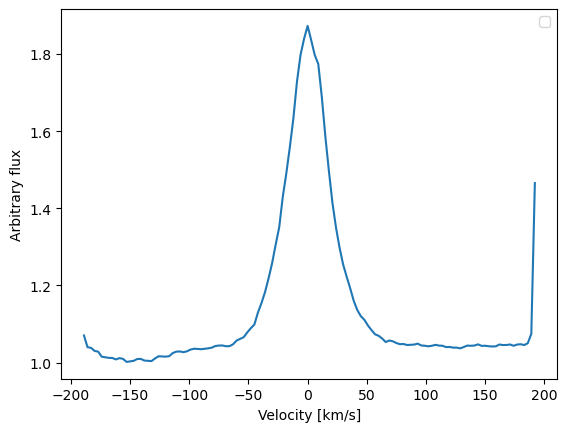

In [5]:
# slabspec line shape
lineshape_data=make_lineshape(wl,flux,lineflux_data)
#lineshape_data=((stackv, stackf+1))

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])
ax1.legend()
ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

In [6]:
lineflux_data

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,lineflux_Gaussian,lineflux_err,linewidth,linewidth_err,v_dop_fit,v_dop_fit_err,continuum,continuum_err,wave_fit,wave_fit_err,amp_fit,amp_fit_err
,,,,,,,,,,,,,,W / m2,,W / m2,km / s,km / s,km / s,km / s,Jy,Jy,micron,micron,Jy,Jy
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,1,1948.2662,13.37,3615.552,1,0,,P 43,85.0,87.0,58407554000000.0,8005.093,5.1327686,2.964302581132766e-17,2.962595469241355e-17,4.7027290721511745e-18,30.13131528757493,2.696416005236325,3.562586560999527,1.0577227374548595,1.11980261843722,0.011493372860330966,5.132829626286889,1.8109348458272845e-05,0.4741097682247407,0.034901100382639695
5,1,1953.4493,13.47,3452.1562,1,0,,P 42,83.0,85.0,58562940000000.0,7777.46,5.1191497,6.631117489384624e-17,6.139217231334804e-17,6.943167705912307e-18,55.58916638056009,2.591953945003465,-5.096563659608087,1.0064094453118677,1.0108438499471433,0.0070900323349026295,5.119062657792561,1.718509074319233e-05,0.5311058372553581,0.020238723448197143
5,1,1958.6035,13.57,3292.4734,1,0,,P 41,81.0,83.0,58717460000000.0,7555.1274,5.1056786,6.804349704448175e-17,6.58873944879814e-17,3.746836235892767e-18,44.839105680062765,1.1357017006674472,-6.246458686468373,0.451864482250291,1.012401554645411,0.004411424420489352,5.105572176720152,7.69557317651086e-06,0.7047865406654721,0.014816148662100126
5,1,1963.7288,13.67,3136.5095,1,0,,P 40,79.0,81.0,58871110000000.0,7338.1045,5.092353,7.084124030865532e-17,6.862800267332756e-17,4.008440578639137e-18,42.805728383242965,1.113699385712578,0.048626069801331946,0.4495617125737594,1.015659332205803,0.004381666489859149,5.0923536931015665,7.636372479975021e-06,0.7669831416078118,0.01671591440060589
5,1,1968.8247,13.78,2984.2708,1,0,,P 39,77.0,79.0,59023880000000.0,7126.399,5.079172,4.478192344940505e-17,1.1779627599097833e-16,3.858678977052217e-18,57.959995394282004,4.594858786974307,14.441819211359164,3.951051160839979,1.0188446073058137,0.004547897489661147,5.0794168119546725,6.693987264257622e-05,0.9698059862199525,0.07073654530310282
5,1,1973.8915,13.89,2835.7627,1,0,,P 38,75.0,77.0,59175780000000.0,6920.019,5.0661345,6.784862084849903e-17,6.37487484768051e-17,6.695090504137613e-18,40.5682787761957,1.9148384385939248,4.256441145583923,0.7754678597901602,1.037650530011624,0.007511843308700419,5.0662063815910745,1.3104480572147628e-05,0.7478865942138563,0.029631865405948577
5,1,1978.9287,13.99,2690.9912,1,0,,P 37,73.0,75.0,59326790000000.0,6718.9727,5.0532393,7.975631083779586e-17,7.776205803196079e-17,8.302778585142039e-18,55.1645012131973,2.539417867985232,17.500687970464856,1.0050509910831387,1.036341889674021,0.007898907720905778,5.053534333508595,1.694093055678498e-05,0.6692233116881788,0.02548215757101602
5,1,1983.9363,14.09,2549.962,1,0,,P 36,71.0,73.0,59476917000000.0,6523.2676,5.0404844,6.566155443485654e-17,6.651624586591655e-17,5.139488754963538e-18,41.95976195261903,1.5628625725242833,5.7206680325270725,0.6317172842232952,1.0419878291707225,0.006063465906880042,5.040580611406263,1.0621218277219959e-05,0.7506596442970817,0.02344331671651693


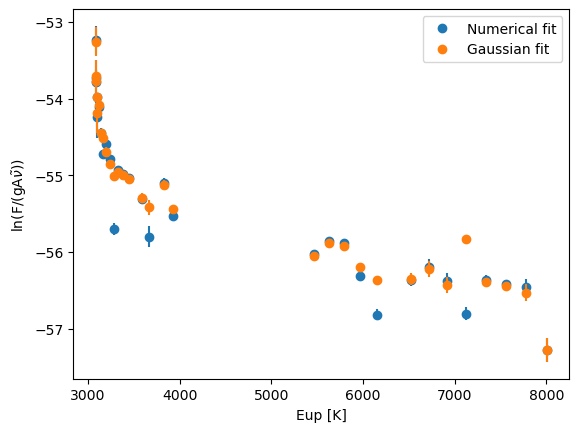

In [7]:
# Rotation diagram
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.errorbar(rot_numerical['x'],rot_numerical['y'],yerr=rot_numerical['yerr'],color='C0',fmt='None')

ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')
ax1.errorbar(rot_Gaussian['x'],rot_Gaussian['y'],yerr=rot_Gaussian['yerr'],color='C1',fmt='None')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

In [8]:
# default 
au=1.5e11 # meters/AU
#Make slab model 
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=distance.,vup=1)

rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

Reading partition function from:  https://hitran.org/data/Q/q26.txt


Text(0, 0.5, 'Line flux [10$^{-16}$ W m$^{-2}$]')

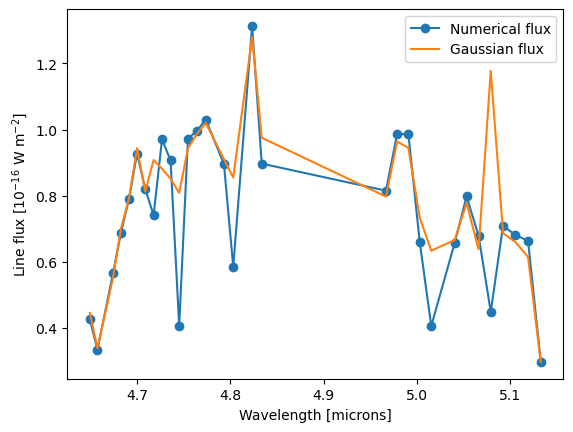

In [9]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16,'-o',label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

Reading partition function from:  https://hitran.org/data/Q/q26.txt


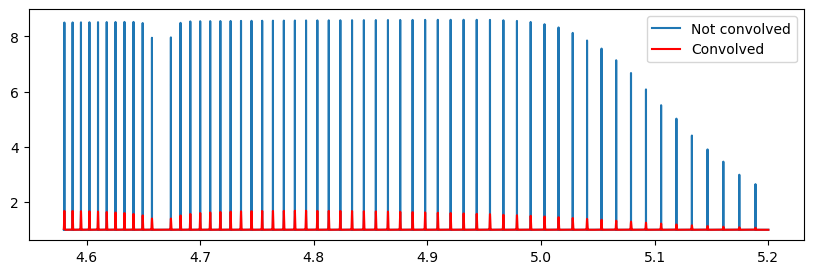

In [13]:
# default 
au=1.5e11
#Make slab model
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30,d_pc=distance,vup=1)


#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

In [14]:
# ?? Should this be input
myconfig=Config('/Users/emmadahl/Desktop/Slabs/config_files/default_config.txt')  #reads config.json by default, or can specify path to file as input parameter
#myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter

myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 300,
 "tmax": 2100,
 "lognmin": 14,
 "lognmax": 26,
 "logomegamin": -22,
 "logomegamax": -10,
 "Nwalkers": 25,
 "Nburnin": 1000,
 "Nsamples": 6000
}


In [75]:
#myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter
#myconfig.display()

{
 "tmin": 100,
 "tmax": 1200,
 "lognmin": 19,
 "lognmax": 24,
 "logomegamin": -19,
 "logomegamax": -12,
 "Nwalkers": 20,
 "Nburnin": 1000,
 "Nsamples": 3000
}


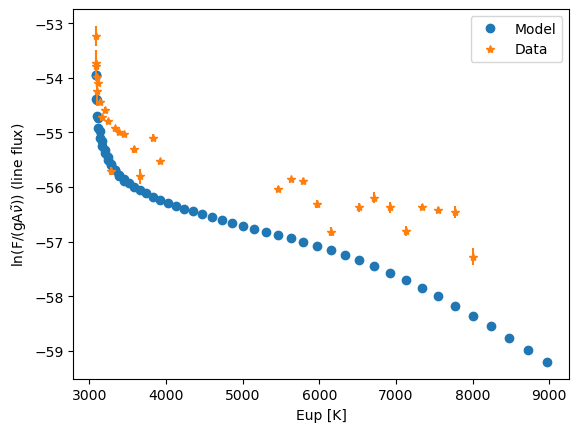

In [15]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.errorbar(rd_data['x'],rd_data['y'],yerr=rd_data['yerr'],color='C1',fmt='None')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$)) (line flux)')
ax1.legend()

In [16]:
mysampler=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
mychain=mysampler.chain
pickle.dump(mychain,open('disk_chain.p','wb'))  #Save for convenience and later retrieval
pickle.dump(mysampler,open('disk_sampler.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Bottle.aiff -v 8')

Number of total samples: 150000
Run time [s]: 195.08984208106995


0

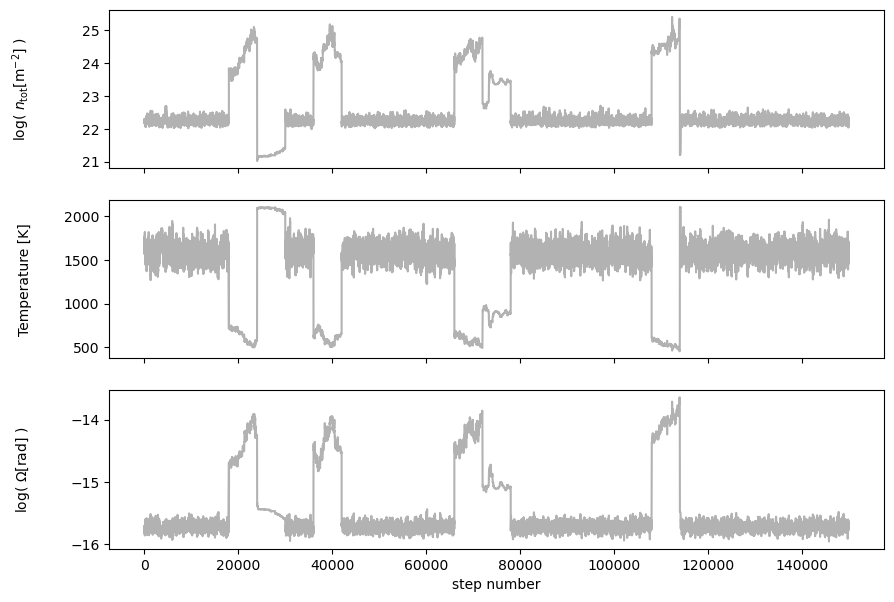

In [17]:
mychain=pickle.load(open('disk_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain
trace_plot(postsamples)

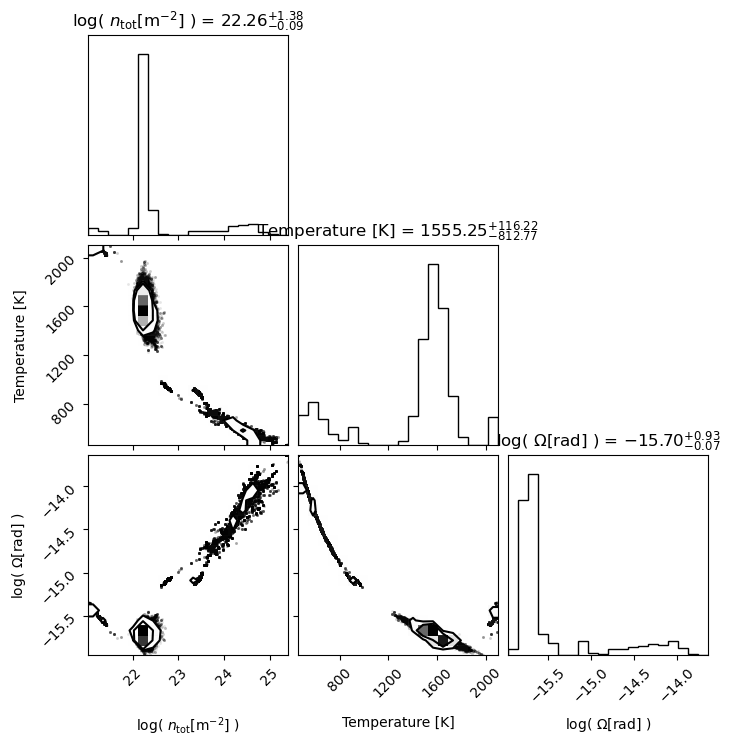

In [18]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [19]:
# !! this is what we want to use as input to slabspec
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

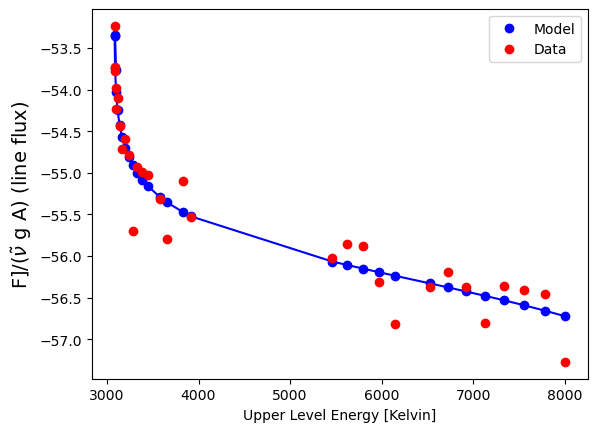

In [20]:
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A) (line flux)',fontsize=14)
ax1.legend()

In [21]:
# save this info to file to use as input for iris, include chemical abundance tied to the specific chemical modeled
best_fit

{'logN': 22.257698689612326,
 'logN_perr': 1.3769643241711762,
 'logN_nerr': 0.09217184550933766,
 'T': 1555.2481373491833,
 'T_perr': 116.21892780489293,
 'T_nerr': 812.7704495564228,
 'logOmega': -15.697299552503662,
 'logOmega_perr': 0.9264322856706411,
 'logOmega_nerr': 0.07249228233185256}